## Mini-project for LLM course

### Requirements

In [ ]:
!pip install os
!pip install pandas
!pip install dotenv
!pip install random
!pip install openai
!pip install langchain_core
!pip install langchain_ollama

In [53]:
import pandas as pd 
import random
import os 
from dotenv import load_dotenv
from openai import OpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA

In [54]:
# Load OPENAI API KEY present in the .env file
load_dotenv(".env")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [ ]:
def read_xl_wic_file(file_path):
    """
    Reads XL-WiC format txt file and converts to DataFrame.
    Format: target_word \t PoS \t start_idx1 \t end_idx1 \t start_idx2 \t end_idx2 \t example1 \t example2 \t label

    The files follow a tab-separated format:
    target_word <tab> PoS <tab> start-char-index_1 <tab> end-char-index_1 <tab> start-char-index_2 <tab> end-char-index_2 <tab> example_1 <tab> example_2 <tab> label

    - "target_word": the target word which is present in both examples.
    - "PoS": the Part-of-Speech tag of the target word (either "N": noun or "V": verb).
    - "start-index_i": indicates the start char index of target_word in "i"th example. 
    - "end-index_i": indicates the end char index of target_word in "i"th example. 
    - "example_i": corresponds to the "i"th example.
    - "label": can be 1 or 0 depending on whether the intended sense of the target word is the same in both examples (1) or not (0).
    """
    columns = [
        'target_word', 'pos', 
        'start_idx1', 'end_idx1', 
        'start_idx2', 'end_idx2',
        'example1', 'example2', 
        'label'
    ]
    
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            row = [item.strip() for item in line.split('\t')]
            if len(row) == len(columns):
                # Convert indices and label to integers
                row[2:6] = [int(x) for x in row[2:6]]  # Convert all indices
                row[-1] = int(row[-1])  # Convert label
                data.append(row)
    
    return pd.DataFrame(data, columns=columns)

df = read_xl_wic_file('/home/max/Desktop/UNI_Bielefeld/LLM/xlwic_wn_xlingual/xlwic_wn_xlingual/train_en.txt')

In [ ]:
def sample_xl_wic_pairs(df, n_samples=5, seed=None):
    """
    Samples random word pairs from XL-WiC dataset and formats them for LLM evaluation
    """
    if seed:
        random.seed(seed)
    
    samples = df.sample(n=n_samples)
    formatted_samples = []
    
    for _, row in samples.iterrows():
        sample_dict = {
            'word': row['target_word'],
            'pos': 'Noun' if row['pos'] == 'N' else 'Verb',
            'sentence1': row['example1'],
            'sentence2': row['example2'],
            'true_label': row['label'],
            'meaning': 'same' if row['label'] == 1 else 'different'
        }
        formatted_samples.append(sample_dict)
    
    return formatted_samples

In [ ]:
samples = sample_xl_wic_pairs(df, n_samples=5)
# Checking how dataset is constructed
for sample in samples:
    print(f"\nTarget word: {sample['word']} ({sample['pos']})")
    print(f"Sentence 1: {sample['sentence1']}")
    print(f"Sentence 2: {sample['sentence2']}")
    print(f"True label: {sample['meaning']} meaning ({sample['true_label']})")


Target word: carry (Verb)
Sentence 1: You must carry your camping gear.
Sentence 2: Amanda carried the package.
True label: same meaning (1)

Target word: softness (Noun)
Sentence 1: The climate had the softness of the south of France.
Sentence 2: Softness is not something permitted of good leaders.
True label: different meaning (0)

Target word: run (Verb)
Sentence 1: Run a new program on the Mac.
Sentence 2: I will run the sample.
True label: same meaning (1)

Target word: hit (Verb)
Sentence 1: He hit her hard in the face.
Sentence 2: He hit a home run.
True label: different meaning (0)

Target word: day (Noun)
Sentence 1: Day and night.
Sentence 2: The dawn turned night into day.
True label: same meaning (1)


In [61]:
# eval with OPENAI models
def evaluate_with_llm_OPENAI(samples):
    client = OpenAI()
    results = []
    
    for sample in samples:
        prompt = f"Sentence 1: {sample['sentence1']}\nSentence 2: {sample['sentence2']}"
        
        completion = client.chat.completions.create(
            model="gpt-3.5-turbo-0125",
            messages=[
                {"role": "system", "content": "You are a helpful assistant. My goal is to check if a target word in a sentence has the same intended sense in another sentence. A target word and two sentences will be passed. Check if the intended sense is the same or not. Label as (1) if the meaning is the same, viceversa (0) for different meaning. In the final response you always add a line where you write the correct Label you think it is, starting in the following way: Label"},
                {"role": "user", "content": prompt}
            ]
        )
        
        llm_response = completion.choices[0].message.content
        results.append({
            'word': sample['word'],
            'true_label': sample['true_label'],
            'llm_response': llm_response
        })
    
    return results

# eval with PHI3 model
def evaluate_with_llm_PHI3(samples):
    MODEL = OllamaLLM(model="phi3")
    TEMPLATE = """You are a helpful assistant. My goal is to check if a target word in a sentence has the same intended sense in another sentence. A target word and two sentences will be passed. Check if the intended sense is the same or not. Label as (1) if the meaning is the same, viceversa (0) for different meaning. In the final response you always add a line where you write the correct Label you think it is, starting in the following way: Label.

{question}"""
    
    results = []
    prompt = ChatPromptTemplate.from_template(TEMPLATE)
    chain = prompt | MODEL
    
    for sample in samples:
        question = f"Sentence 1: {sample['sentence1']}\nSentence 2: {sample['sentence2']}"
        response = chain.invoke({"question": question})
        
        results.append({
            'word': sample['word'],
            'true_label': sample['true_label'],
            'llm_response': response
        })
    
    return results

In [63]:
samples = sample_xl_wic_pairs(df, n_samples=3)
results = evaluate_with_llm_OPENAI(samples)
# results = evaluate_with_llm_PHI3(samples)

for r in results:
    print(f"\nWord: {r['word']}")
    print(f"True label: {r['true_label']}")
    print(f"LLM response: {r['llm_response']}")
    print("-------------")


Word: range
True label: 1
LLM response: The target word is "range". In the first sentence, "range" refers to an area of land where military exercises or testing can be conducted. In the second sentence, "range" refers to an area for practicing golf shots. The intended sense of "range" is different in these two sentences.

Label 0
-------------

Word: baron
True label: 1
LLM response: The target word is "baron."

In sentence 1, "baron" is used in the context of a historical term of disdain for powerful and wealthy individuals. In sentence 2, "baron" is used in the context of a powerful and wealthy individual in the oil industry.

Therefore, the intended sense of "baron" is different in the two sentences.

Label 0
-------------

Word: work
True label: 0
LLM response: The target word is "work" in both sentences.

The intended sense of "work" in both sentences is different:
- In the first sentence, "work" refers to employment or job.
- In the second sentence, "work" refers to the place of

### Playing with embeddings

In [10]:
def get_embeddings_for_probing(samples):
    client = OpenAI()
    embeddings_data = []
    
    for sample in samples:
        # get embeddings for each sentence using text-embedding-ada-002
        sentence1_embedding = client.embeddings.create(
            input=sample['sentence1'],
            model="text-embedding-ada-002"
        ).data[0].embedding
        
        sentence2_embedding = client.embeddings.create(
            input=sample['sentence2'],
            model="text-embedding-ada-002"
        ).data[0].embedding
        
        embeddings_data.append({
            'word': sample['word'],
            'embeddings': (sentence1_embedding, sentence2_embedding),
            'label': sample['true_label']   
        })
    
    return embeddings_data

In [30]:
# Get the embeddings for the dataset samples sentences
embeddings_data = get_embeddings_for_probing(samples)

In [ ]:
def visualize_word_embeddings_2d(embeddings_data):
    X = np.array([np.concatenate(sample['embeddings']) for sample in embeddings_data])
    labels = np.array([sample['label'] for sample in embeddings_data])
    words = np.array([sample['word'] for sample in embeddings_data])
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(12, 8))    
    for i in range(len(X_pca)):
        circle = plt.Circle((X_pca[i, 0], X_pca[i, 1]), 
                          radius=0.2,  # Adjust radius as needed
                          color='red' if labels[i] == 1 else 'blue',
                          alpha=0.2)
        plt.gca().add_patch(circle)
        plt.annotate(words[i], 
                    (X_pca[i, 0], X_pca[i, 1]),
                    fontsize=10,
                    ha='center',
                    va='center')
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.title('2D Word Sense Embedding Space')
    
    legend_elements = [Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='red', markersize=10,
                            label='Same Sense'),
                      Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='blue', markersize=10,
                            label='Different Sense')]
    plt.legend(handles=legend_elements)
    plt.gca().set_aspect('equal')
    plt.margins(0.2)
    plt.tight_layout()
    
    return pca, plt.gcf()

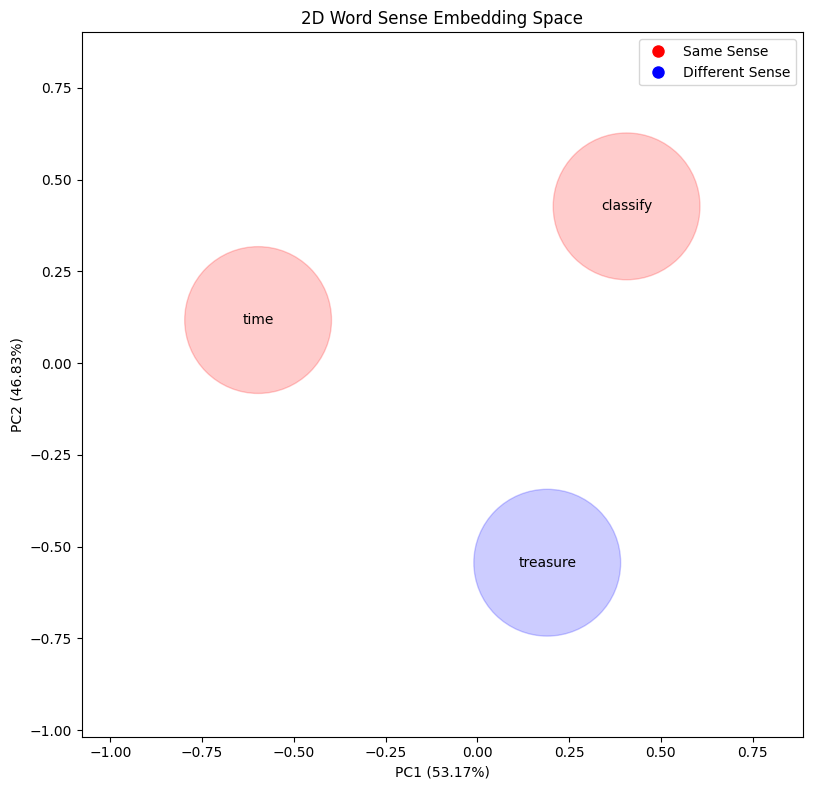

In [52]:
pca_model, fig = visualize_word_embeddings_2d(embeddings_data)
plt.show()

In [ ]:
def visualize_word_embeddings_3d_static(embeddings_data, views=[(30, 45), (30, 135), (30, 225), (30, 315)]):
    X = np.array([np.concatenate(sample['embeddings']) for sample in embeddings_data])
    labels = np.array([sample['label'] for sample in embeddings_data])
    words = np.array([sample['word'] for sample in embeddings_data])
    
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    
    fig = plt.figure(figsize=(20, 5))
    
    for idx, (elev, azim) in enumerate(views, 1):
        ax = fig.add_subplot(1, len(views), idx, projection='3d')
        
        ax.quiver(0, 0, 0, 1, 0, 0, color='r', alpha=0.5, lw=2)
        ax.quiver(0, 0, 0, 0, 1, 0, color='g', alpha=0.5, lw=2)
        ax.quiver(0, 0, 0, 0, 0, 1, color='b', alpha=0.5, lw=2)
        
        colors = plt.cm.rainbow(np.linspace(0, 1, len(X_pca)))
        for i, (point, word, color) in enumerate(zip(X_pca, words, colors)):
            ax.quiver(0, 0, 0, point[0], point[1], point[2],
                     color=color, alpha=0.6)
            
            ax.text(point[0], point[1], point[2], 
                    word,
                    color=color,
                    fontsize=10)
        
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.set_box_aspect([1,1,1])
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])        
        ax.grid(True, alpha=0.3)
        ax.set_title(f'View from {azim}°')
    
    plt.suptitle('Word Embeddings Visualization - Multiple Views', y=1.05)
    plt.tight_layout()
    return pca, fig

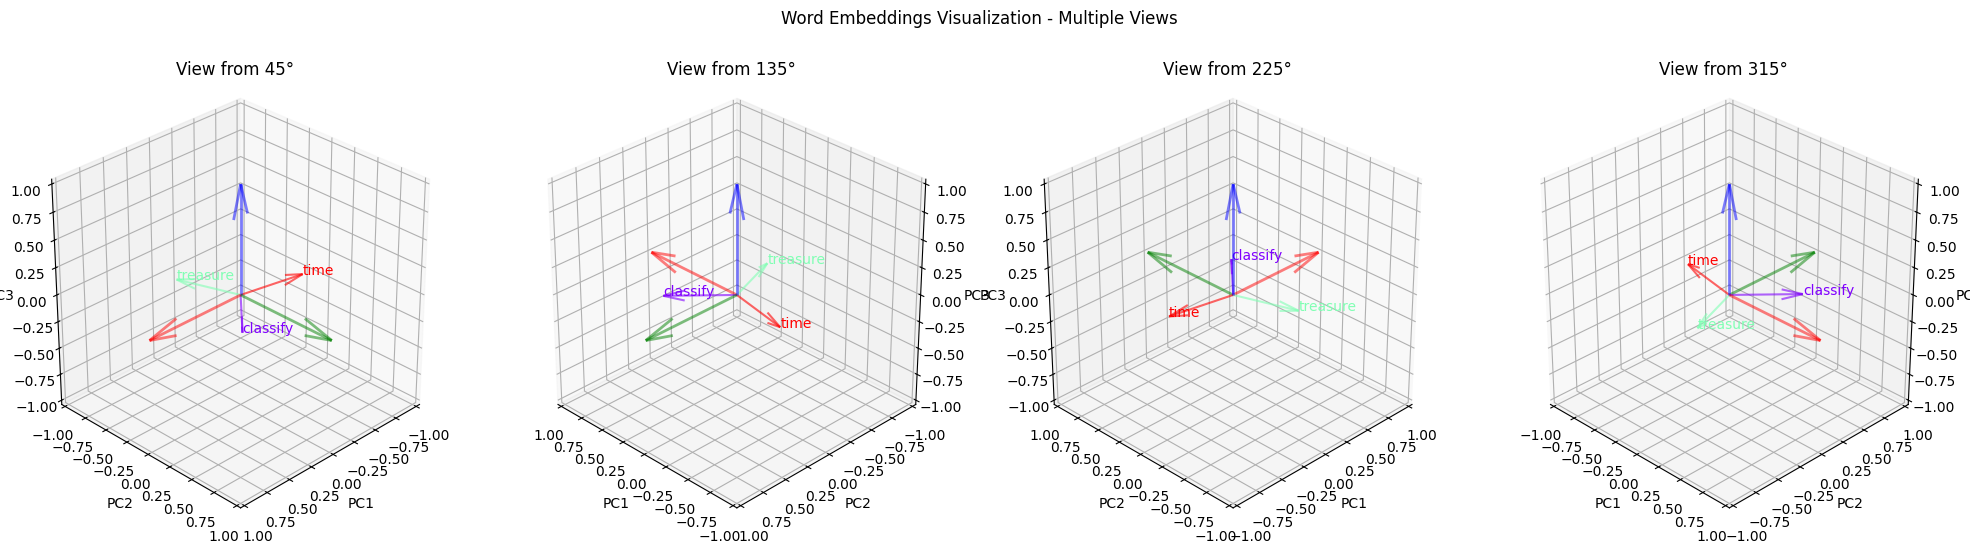

In [51]:
visualize_word_embeddings_3d_static(embeddings_data)
plt.show()

In [ ]:
def visualize_sentence_embeddings_comparison(embeddings_data):
    sentences1_embeddings = np.array([sample['embeddings'][0] for sample in embeddings_data])
    sentences2_embeddings = np.array([sample['embeddings'][1] for sample in embeddings_data])
    labels = np.array([sample['label'] for sample in embeddings_data])
    words = np.array([sample['word'] for sample in embeddings_data])
    all_embeddings = np.vstack([sentences1_embeddings, sentences2_embeddings])
    
    pca = PCA(n_components=3)
    all_embeddings_pca = pca.fit_transform(all_embeddings)
    
    n_samples = len(embeddings_data)
    sent1_pca = all_embeddings_pca[:n_samples]
    sent2_pca = all_embeddings_pca[n_samples:]
    
    fig = plt.figure(figsize=(20, 5))
    views = [(30, 45), (30, 135), (30, 225), (30, 315)]
    
    for idx, (elev, azim) in enumerate(views, 1):
        ax = fig.add_subplot(1, len(views), idx, projection='3d')
        
        for i in range(n_samples):
            ax.plot([sent1_pca[i, 0], sent2_pca[i, 0]],
                   [sent1_pca[i, 1], sent2_pca[i, 1]],
                   [sent1_pca[i, 2], sent2_pca[i, 2]],
                   color='red' if labels[i] == 1 else 'blue',
                   alpha=0.5,
                   linestyle='--')
            
            ax.scatter(sent1_pca[i, 0], sent1_pca[i, 1], sent1_pca[i, 2],
                      color='red' if labels[i] == 1 else 'blue',
                      marker='o')
            ax.scatter(sent2_pca[i, 0], sent2_pca[i, 1], sent2_pca[i, 2],
                      color='red' if labels[i] == 1 else 'blue',
                      marker='^')
            ax.text(sent1_pca[i, 0], sent1_pca[i, 1], sent1_pca[i, 2],
                   f'{words[i]}_1', fontsize=8)
            ax.text(sent2_pca[i, 0], sent2_pca[i, 1], sent2_pca[i, 2],
                   f'{words[i]}_2', fontsize=8)
        
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(f'View from {elev}°, {azim}°')
        
    plt.suptitle('Sentence Embeddings Comparison\nRed: Same Sense, Blue: Different Sense')
    plt.tight_layout()
    
    # legend
    handles = [
        plt.Line2D([0], [0], color='red', label='Same Sense'),
        plt.Line2D([0], [0], color='blue', label='Different Sense'),
        plt.Line2D([0], [0], marker='o', color='gray', label='Sentence 1', linestyle='None'),
        plt.Line2D([0], [0], marker='^', color='gray', label='Sentence 2', linestyle='None')
    ]
    fig.legend(handles=handles, loc='center right')
    
    return pca, fig

In [ ]:
def visualize_target_word_embeddings(embeddings_data):
    """
    Visualize embeddings for the target word in both sentences.
    Red for same sense, Blue for different sense.
    """
    target_words = np.array([sample['word'] for sample in embeddings_data])
    labels = np.array([sample['label'] for sample in embeddings_data])
    word1_embeddings = np.array([sample['embeddings'][0] for sample in embeddings_data])
    word2_embeddings = np.array([sample['embeddings'][1] for sample in embeddings_data])
    all_embeddings = np.vstack([word1_embeddings, word2_embeddings])
    
    pca = PCA(n_components=3)
    all_embeddings_pca = pca.fit_transform(all_embeddings)
    n_samples = len(embeddings_data)
    word1_pca = all_embeddings_pca[:n_samples]
    word2_pca = all_embeddings_pca[n_samples:]
    
    fig = plt.figure(figsize=(20, 5))
    views = [(30, 45), (30, 135), (30, 225), (30, 315)]
    
    for idx, (elev, azim) in enumerate(views, 1):
        ax = fig.add_subplot(1, len(views), idx, projection='3d')
        
        for i in range(n_samples):
            color = 'red' if labels[i] == 1 else 'blue'
            
            ax.plot([word1_pca[i, 0], word2_pca[i, 0]],
                   [word1_pca[i, 1], word2_pca[i, 1]],
                   [word1_pca[i, 2], word2_pca[i, 2]],
                   color=color, alpha=0.5, linestyle='--')
            
            ax.scatter(word1_pca[i, 0], word1_pca[i, 1], word1_pca[i, 2],
                      color=color, marker='o')
            ax.scatter(word2_pca[i, 0], word2_pca[i, 1], word2_pca[i, 2],
                      color=color, marker='^')
            ax.text(word1_pca[i, 0], word1_pca[i, 1], word1_pca[i, 2],
                   f'{target_words[i]}_ctx1', fontsize=8)
            ax.text(word2_pca[i, 0], word2_pca[i, 1], word2_pca[i, 2],
                   f'{target_words[i]}_ctx2', fontsize=8)
        
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(f'View from {elev}°, {azim}°')
        ax.set_box_aspect([1,1,1])
        
    plt.suptitle('Target Word Embeddings in Different Contexts\nRed: Same Sense, Blue: Different Sense')
    
    # legend
    handles = [
        plt.Line2D([0], [0], color='red', label='Same Sense'),
        plt.Line2D([0], [0], color='blue', label='Different Sense'),
        plt.Line2D([0], [0], marker='o', color='gray', label='Context 1', linestyle='None'),
        plt.Line2D([0], [0], marker='^', color='gray', label='Context 2', linestyle='None')
    ]
    fig.legend(handles=handles, loc='center right')
    
    plt.tight_layout()
    return pca, fig

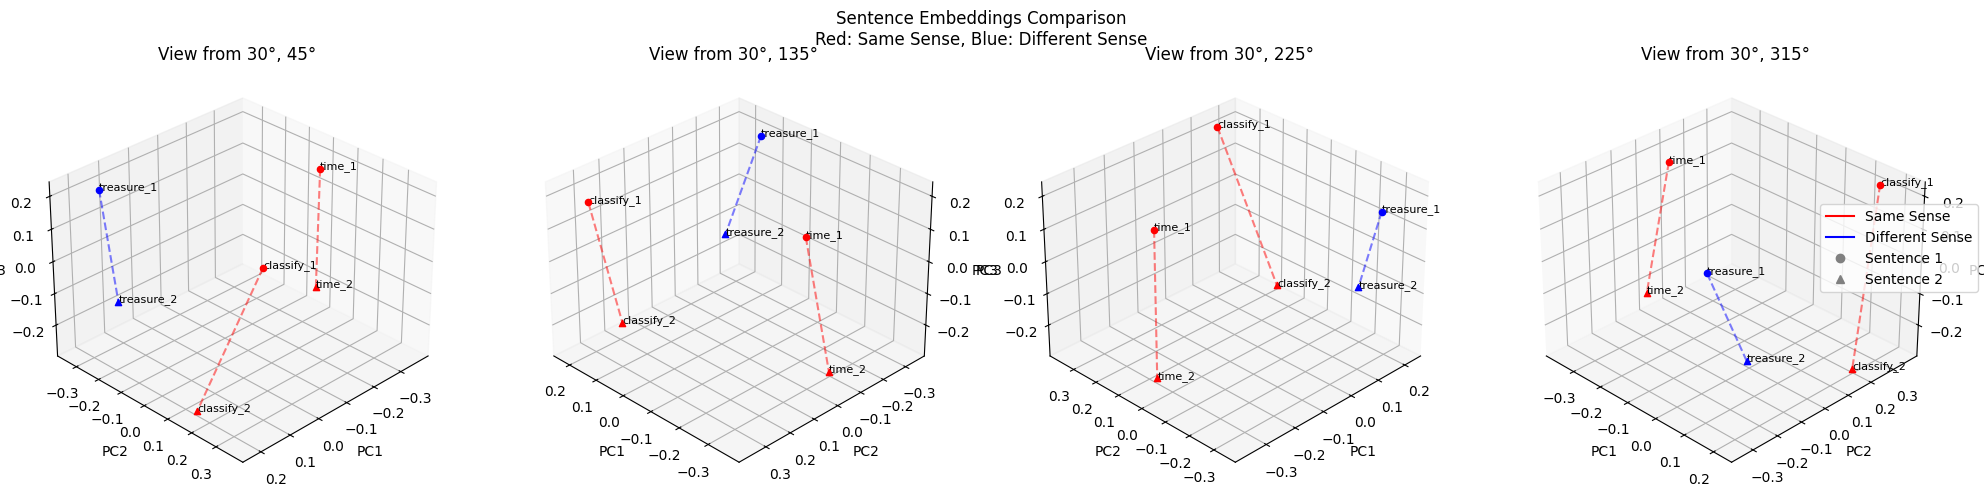

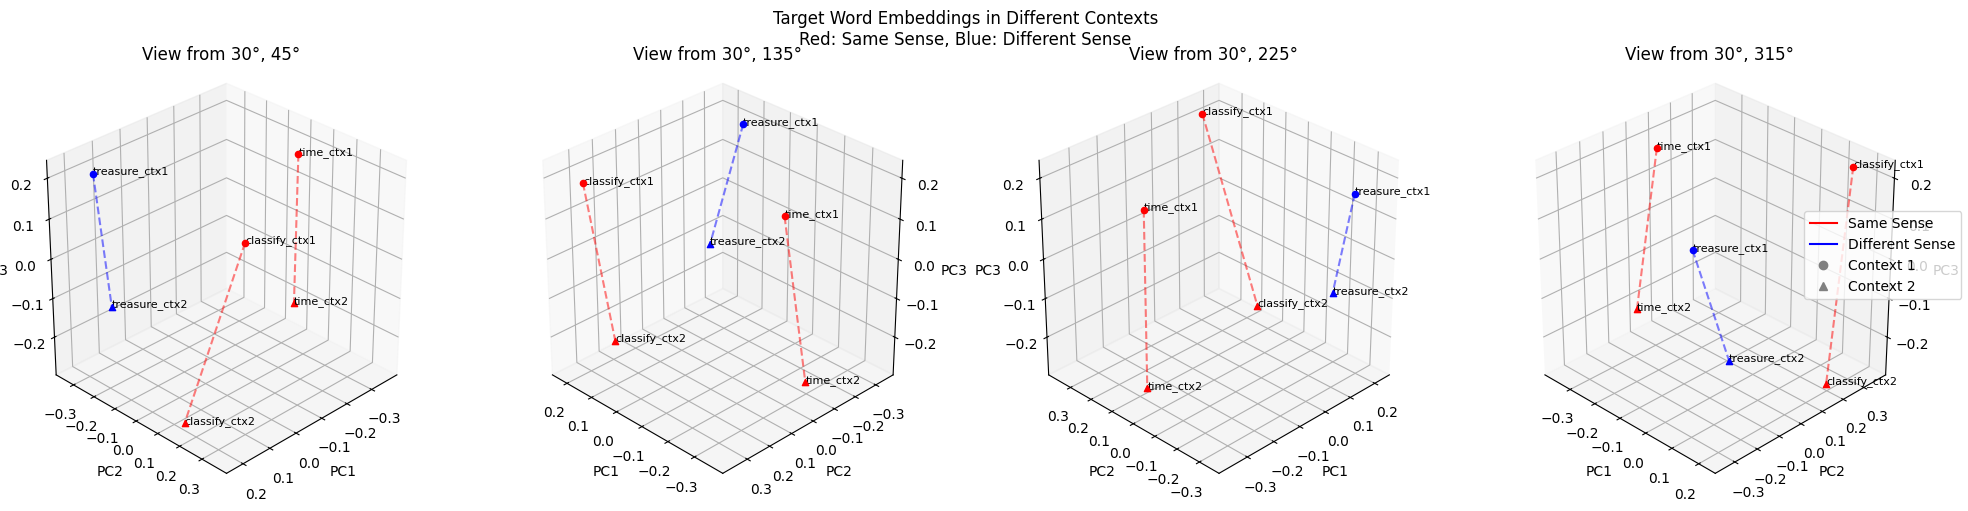

In [ ]:
pca_model_sentences, fig_sentences = visualize_sentence_embeddings_comparison(embeddings_data)
pca_model_target_word, fig_target_word = visualize_target_word_embeddings(embeddings_data)
plt.show()

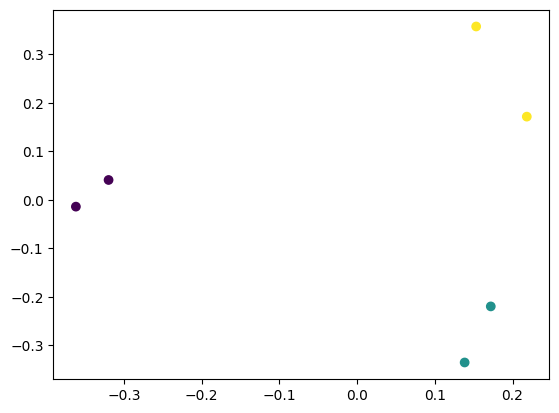

In [ ]:
def analyze_sense_clusters(embeddings_data):
    from sklearn.cluster import KMeans
    
    all_embeddings = np.vstack([emb for sample in embeddings_data 
                               for emb in sample['embeddings']])
    
    kmeans = KMeans(n_clusters=3)
    clusters = kmeans.fit_predict(all_embeddings)
    
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(all_embeddings)
    
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                c=clusters, cmap='viridis')
analyze_sense_clusters(embeddings_data)